# Autism Prediction - NLP Extraction Using `pylangacq` and Evaluation on Different Synthetic Data Generation Techniques in Comparison with Baseline Data Performance using Random Forest Classifier.

## NLP Extraction
Few things that would be done in this notebook.

To help with our thought process, we will do the following in this notebook:

- Extract Nadig with different features for prediction of the label (ASD or not)
- Extract the features using the `pylangacq` library and features provided by `Gustavo Cunha`
- Use the dataset for modeling, to see a baseline performance
- Generate synthetic data and see how each performs on each dataset using different techniques
- Merge two best synthetic data for quantity and balanced classification and see how this performs.
- Tune the hyperparameters of the best model to see if we can have a MVP.

In [1]:
# install pylangacq
!pip install --upgrade -q pylangacq;

In [2]:
# Import relevant libraries
import re
import numpy as np
import pandas as pd

# NLP 
import pylangacq
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# set cientific notation for pandas
pd.set_option(
    "display.float_format", "{:,.3f}".format 
)

seed = 0

In [3]:
# Load file from path
file_path = "/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/Nadig.zip"
df = pylangacq.read_chat(file_path)

# create an empty dataframe 
df_extraction = pd.DataFrame()

# iterate over transcripts
for df_i in df:
    # create a dictionary for extracted features
    features_dict = {}
    
    ####### add values to dataframe #######
    # add ASD label
    features_dict["ASD"] = df_i.headers()[0]["Participants"]["CHI"]["group"]
    
    # get non-child participants tags
    non_child_participants = list(df_i.headers()[0]["Participants"].keys())
    non_child_participants.remove('CHI')

    # get mlu
    child_mlu = df_i.mlu(participant='CHI')[0]    
    # get mean mlu for non-child participants
    mean_mlu_non_child = np.mean([df_i.mlu(participant=non_child)[0] 
                                  for non_child 
                                  in non_child_participants])
    # add child mlu
    features_dict["child_mlu"] = child_mlu
    # get percentage of child mlu / non-child mean mlu
    features_dict["percent_child_parents_mlu"] = child_mlu / mean_mlu_non_child

    # get mluw
    child_mluw = df_i.mluw(participant='CHI')[0]
    # get mean mluw for non-child participants
    mean_mluw_non_child = np.mean([df_i.mluw(participant=non_child)[0] 
                                  for non_child 
                                  in non_child_participants])
    # add child mluw
    features_dict["child_mluw"] = child_mluw
    # get percentage of child mluw / non-child mean mluw
    features_dict["percent_child_parents_mluw"] = child_mluw / mean_mluw_non_child

    # get ttr
    child_ttr = df_i.ttr(participant='CHI')[0]
    # get mean ttr for non-child participants
    mean_ttr_non_child = np.mean([df_i.ttr(participant=non_child)[0] 
                                  for non_child 
                                  in non_child_participants])
    # add child ttr
    features_dict["child_ttr"] = child_ttr
    # get percentage of child ttr / non-child mean ttr
    features_dict["percent_child_parents_ttr"] = child_ttr / mean_ttr_non_child

    # get ipsyn
    child_ipsyn = df_i.ipsyn(participant='CHI')[0]
    # get mean ipsyn for non-child participants
    mean_ipsyn_non_child = np.mean([df_i.ipsyn(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_participants])
    # add child ipsyn
    features_dict["child_ipsyn"] = child_ipsyn
    # get percentage of child ipsyn / non-child mean ipsyn
    features_dict["percent_child_parents_ipsyn"] = child_ipsyn / mean_ipsyn_non_child

    # get number of words
    features_dict["child_num_words"] = len(df_i.words(participants="CHI"))
    # get percentage of child words / parent words
    features_dict["perct_child_parents_words"] = len(df_i.words(participants="CHI")) / len(df_i.words(exclude=("CHI")))
    # get number of unique words
    features_dict["child_num_unique_words"] = len(set(df_i.words(participants="CHI")))
    # get percentage of child unique words / parent unique words
    features_dict["perct_child_parents_unique_words"] = len(set(df_i.words(participants="CHI"))) / len(set(df_i.words(exclude=("CHI"))))

    # get number of tokens
    features_dict["child_num_tokens"] = len(df_i.tokens(participants="CHI"))
    # get percentage of child tokens / parent tokens
    features_dict["perct_child_parents_tokens"] = len(df_i.tokens(participants="CHI")) / len(df_i.tokens(exclude=("CHI")))

    # get number of utterances
    features_dict["child_utterances"] = len(df_i.utterances(participants="CHI"))
    # get percentage of child utterances / parent utterances
    features_dict["perct_child_parents_utterances"] = len(df_i.utterances(participants="CHI")) / len(df_i.utterances(exclude="CHI"))

    # get part of speech (POS) for every token in child utterances
    child_pos = [token.pos for token in df_i.tokens(participants="CHI")]   
    # get number of tokens
    num_tokens = features_dict["child_num_tokens"]
    # sanity check
    assert num_tokens == len(child_pos), "Missing POS tags!"
    
    # get values counts for pos
    pos_value_counts = pd.Series(child_pos).value_counts(dropna=False)
    # convert to dict
    pos_value_counts_dict = pos_value_counts.to_dict()
    # add pos_ prefix before pos tags
    pos_value_counts_dict = { ("pos_percent_" + str(k)): (v / num_tokens) for k, v in pos_value_counts_dict.items() }
    # sanity check 
    assert abs(1 - sum([*pos_value_counts_dict.values()])) < 0.01, "Missing POS tags!"
    
    # add pos_value_counts_dict to features_dict
    features_dict = {**features_dict, **pos_value_counts_dict}
    # create a pandas dataframe from features dict
    df_features = pd.DataFrame(data=features_dict, index=[0])

    # concatenate features dataframe with extraction dataframe
    df_extraction = pd.concat(objs=[df_extraction, df_features], ignore_index=True)

In [4]:
# Copy our extracted dataset
df = df_extraction.copy()

# Export our extracted dataset
df.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nadig_extracted.csv', index=False)

# check columns with null values
df.isna().sum()

ASD                            0
child_mlu                      0
percent_child_parents_mlu      0
child_mluw                     0
percent_child_parents_mluw     0
                              ..
pos_percent_chi               33
pos_percent_pro:poss          34
pos_percent_n:let             37
pos_percent_bab               36
pos_percent_sing              37
Length: 70, dtype: int64

Since we have some missing values, we will replace them all with 0.

In [5]:
# fill missing values with 0
df.fillna(value=0, inplace=True)

# sanity check
assert df.isna().sum().sum() == 0, "There are missing values!"

In [6]:
# Display summary statistics of the numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mlu,38.000,3.042,1.497,1.000,1.897,2.854,3.961,7.855
percent_child_parents_mlu,38.000,0.538,0.239,0.198,0.346,0.509,0.686,1.203
child_mluw,38.000,2.482,1.249,0.000,1.414,2.582,3.283,6.642
percent_child_parents_mluw,38.000,0.558,0.250,0.000,0.347,0.545,0.737,1.277
child_ttr,38.000,0.463,0.174,0.000,0.392,0.442,0.517,1.000
...,...,...,...,...,...,...,...,...
pos_percent_chi,38.000,0.000,0.001,0.000,0.000,0.000,0.000,0.005
pos_percent_pro:poss,38.000,0.001,0.002,0.000,0.000,0.000,0.000,0.008
pos_percent_n:let,38.000,0.000,0.001,0.000,0.000,0.000,0.000,0.004
pos_percent_bab,38.000,0.003,0.013,0.000,0.000,0.000,0.000,0.075


In [7]:
# Replace ASD and TYP label with 1 and 0 in our target column
df['ASD'] = df['ASD'].replace({"ASD": 1, "TYP": 0})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ASD                               38 non-null     int64  
 1   child_mlu                         38 non-null     float64
 2   percent_child_parents_mlu         38 non-null     float64
 3   child_mluw                        38 non-null     float64
 4   percent_child_parents_mluw        38 non-null     float64
 5   child_ttr                         38 non-null     float64
 6   percent_child_parents_ttr         38 non-null     float64
 7   child_ipsyn                       38 non-null     int64  
 8   percent_child_parents_ipsyn       38 non-null     float64
 9   child_num_words                   38 non-null     int64  
 10  perct_child_parents_words         38 non-null     float64
 11  child_num_unique_words            38 non-null     int64  
 12  perct_chil

Based on the information above, there are 38 records with no null values, 69 features and `ASD` which is the target variable. Also, all our features are numeric.



## Generating Synthetic Model

We will generate synthetic data and evaluate their performance based on the same condition, using the baseline data from our extraction as a benchmark.

There are few techniques we will use to generate our synthetic data, and do a simple evaluation on each one using thesame method, to see the impact on our model prediction. Few techniques used in this notebook are:

- **Random Oversampling**: This involves randomly duplicating instances from the minority class until the class distribution is balanced. We will use the `RandomOverSampler` from the `imblearn` library to randomly oversample the majority class.
- **Random Undersampling**: This technique involves randomly removing instances from the majority class in order to balance the class distribution. We will also use the `RandomUnderSampler` from the `imblearn` library to randomly undersample the majority class.
- **Near Miss Undersampling**: NearMiss is an under-sampling technique. It is used to undersample the majority class. The technique works by finding the k-nearest samples in the minority class for each sample in the majority class.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: This technique generates synthetic examples of the minority class by interpolating between existing instances.
- **ADASYN (Adaptive Synthetic Sampling)**: This technique generates synthetic examples of the minority class by adaptively adjusting the number of synthetic examples generated for different minority class instances depending on their level of difficulty.
- **Tomek Links**: This technique is based on removing examples that are nearest to the boundary between the two classes, it helps to eliminate the noise and balance the data.
- **Synthetic Data Vault (SDV)**: an ecosystem of libraries that allows users to easily learn datasets to later on generate new Synthetic Data that has the same format and statistical properties as the original dataset.

Note: The aim here is to generate synthetic data and compare performance with the baseline data, there won't be a need to do intensive exploratory data analysis.

At the end, we want to be able to establish if we need synthetic data or not, for predicting autism in toddlers based on the NLP data extracted.

In [9]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#split our data for modelling
from sklearn.model_selection import train_test_split

# Preprocess our data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Generating Synthetic data
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

# Building and evaluating our RandomForest Classifier Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, plot_confusion_matrix
from sklearn import metrics

In [10]:
# view 5 samples in our data
df.sample(5)

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,...,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
4,1,5.213,0.841,4.023,0.832,0.421,0.972,81,0.931,462,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
12,0,3.629,0.497,2.598,0.431,0.445,1.920,66,0.742,372,...,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000
10,0,4.241,0.730,3.753,0.784,0.299,0.777,64,0.865,452,...,0.000,0.006,0.000,0.000,0.009,0.002,0.000,0.000,0.000,0.000
15,1,2.483,0.510,2.275,0.615,0.552,1.987,55,0.671,203,...,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000
6,1,3.625,0.639,3.410,0.793,0.526,2.072,53,0.654,190,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Establishing our Baseline Data Model Performance

Since we are generating synthetic data, we would just be using the default parameters of random forest model with no hyperparameter tuning and with thesame random seed and traintest split throughout, to enable us compare the performance across the different datasets.

Furthermore, Since we will be doing a lot of preprocessing with different data, I think it is best to define a function to preprocess and split the data and another one to return our relevant evaluation metrics (the functions were retweaked so many times along the line).

In [11]:
def split_preprocessor(df, target):
  # Split the data into train and test sets
  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Identify categorical columns
  cat_cols = [col for col in X_train.columns if X_train[col].dtype=='object']

  # Preprocess the categorical data
  enc = OneHotEncoder(handle_unknown='ignore')
  X_train_cat = enc.fit_transform(X_train[cat_cols])
  X_test_cat = enc.transform(X_test[cat_cols])

  # Preprocess the numerical data
  scaler = StandardScaler()
  X_train_num = scaler.fit_transform(X_train.drop(cat_cols, axis=1))
  X_test_num = scaler.transform(X_test.drop(cat_cols, axis=1))

  # Combine the preprocessed data
  X_train = np.hstack((X_train_cat.toarray(), X_train_num))
  X_test = np.hstack((X_test_cat.toarray(), X_test_num))

  #return the split data
  return X_train, X_test, y_train, y_test

In [12]:
# Define function to return our metrics
def evaluate_model(model, X_test, y_test):
  
  # generate prediction with our model
  y_pred = model.predict(X_test)

  # Generate different metric value
  f1_score_value = f1_score(y_test, y_pred)
  roc_auc_value = roc_auc_score(y_test, y_pred)
  accuracy_value = accuracy_score(y_test, y_pred)
  precision_value = precision_score(y_test, y_pred)
  recall_value = recall_score(y_test, y_pred)

  print("\033[1m\033[4mMETRICS\033[0m")
  print("F1 score: {:.2f}".format(f1_score_value))
  print("ROC-AUC: {:.2f}".format(roc_auc_value))
  print("Accuracy: {:.2f}".format(accuracy_value))
  print("Precision: {:.2f}".format(precision_value))
  print("Recall: {:.2f}".format(recall_value))

  # Display line break
  print("\n")

  # classification report
  cr = classification_report(y_test, y_pred)
  print(cr)

  # Display line break
  print("\n")

  # Plotting our confusion matrix
  plot_confusion_matrix(model, X_test, y_test, display_labels=["ASD Trait Absent", "ASD Trait Present"])
  plt.show()

We will also define a function to help us append the metrics of each model into a table for later comparison. The function will append the F1 score, ROC-AUC, accuracy, precision, recall of a fitted model to a table we would specify, such that once it is applied to another fitted model, it adds the metrics to a new line when called. Also, if the column name is not already available at first, this should be automatically added. We should also be able to add some description of the model as a column in the table, when calling the function.

In [13]:
# Initialize the table to append our evaluation results as we fit each model
model_results = pd.DataFrame(columns=[])

# Define the function to append results for comparison
def append_metrics(model, X_test, y_test, table, data_desc=None):
  y_pred = model.predict(X_test)

  f1_score_value = f1_score(y_test, y_pred)
  roc_auc_value = roc_auc_score(y_test, y_pred)
  accuracy_value = accuracy_score(y_test, y_pred)
  precision_value = precision_score(y_test, y_pred)
  recall_value = recall_score(y_test, y_pred)

  metrics = {
      "Data Description": data_desc,
      "F1 Score": f1_score_value,
      "ROC AUC": roc_auc_value,
      "Accuracy": accuracy_value,
      "Precision": precision_value,
      "Recall": recall_value
  }

  for metric_name, value in metrics.items():
      if metric_name not in table.columns:
          table[metric_name] = None
          
  new_row = pd.DataFrame(metrics, index=[0])
  table = table.append(new_row, ignore_index=True)

  return table

Let's also iniate our Random Forest model here, since we will be using thesame model throughout.

In [14]:
# Define the random forest classifier
model = RandomForestClassifier(random_state=42)

### Modelling our Baseline Data

As mentioned earlier, we will model our data to generate predictions using Random Forest Classifier, since this is a binary classification. Afterwards, we will generate synthetic data on the training data and overall baseline dataset using different techniques, and go through thesame predictive modelling process, to see if there would be an improvement on the prediction. By the way, our main focus is the evaluation on the test data, since this is data our model has never seen before.

In [15]:
# copy df into a new dataframe
df_baseline = df.copy()
df_baseline.head()

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,...,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,0,2.641,0.398,2.604,0.472,0.558,2.215,61,0.701,212,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,1.105,0.218,1.000,0.265,0.500,2.556,2,0.026,21,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,3.158,0.449,2.719,0.501,0.394,1.218,57,0.606,233,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,2.394,0.462,1.979,0.488,0.527,1.905,40,0.519,165,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1,5.213,0.841,4.023,0.832,0.421,0.972,81,0.931,462,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [16]:
# Counts the number of each class in our label
df_baseline.ASD.value_counts()

0    25
1    13
Name: ASD, dtype: int64

We have imbalanced class, in which we have more class of non ASD than ASD. However, we expect to see this impact our model prediction.

In [17]:
# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline, 'ASD')

# Fit the model to the training data
df_baseline_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_model, X_test, y_test, model_results, data_desc="baseline dataset")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30





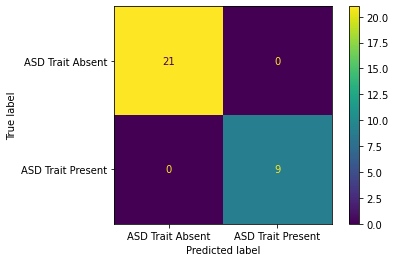

In [18]:
# Evaluate on the training set
evaluate_model(df_baseline_model, X_train, y_train)

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





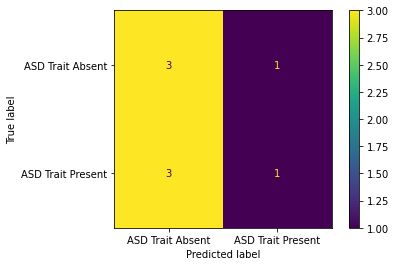

In [19]:
# Evaluate on the test set
evaluate_model(df_baseline_model, X_test, y_test)

Our model ended up overfitting, as it was not able to generalize on the testing dataset, which is explainable with the small dataset. 

## Generating Synthetic data on the Training Dataset Using the Basic Techniques

We will go ahead to generate all our synthetic data and evaluate each, as we move on. 

We would generate our synthetic data on the training set, as this could allow the model to learn from the synthetic examples and generalize to new, unseen data. Additionally, synthetic data generated on the training set can be used to improve the performance of a model on the under-represented class, which is an important aspect of many classification problems. Therefore, we be fitting each technique to the training data, while we use thesame test data to evaluate all the techniques.

Since this will also be an iterative process with the use of different techniques and evaluation with thesame model, to also improve readability, we will also define a function to test each of the classical techniques used in synthesizing data. Kindly note that the relevant library required has been installed earlier.

In [20]:
# define function to synthesize training data and train a model
def model_syn_training_data(model, technique, X_train, y_train):
  # Apply the sampler
  X_train_sampled, y_train_sampled = technique.fit_resample(X_train, y_train)

  # fit our model to the synthetic sampled training data
  df_sampled_model = model.fit(X_train_sampled, y_train_sampled)

  return df_sampled_model

### Implementing and Evaluating Random Oversampling Technique on Training Data

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





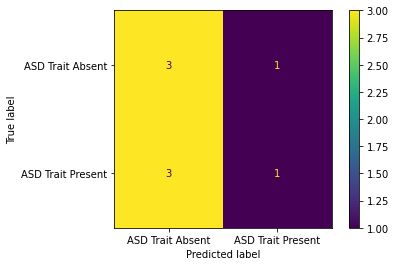

In [21]:
# Implement the random oversampler
df_ro_sampled_model = model_syn_training_data(model, RandomOverSampler(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_ro_sampled_model, X_test, y_test, model_results, data_desc="Random Oversampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_ro_sampled_model, X_test, y_test)

Our trained randomly oversampled training data model performed similarly to the baseline data evaluation on the test data.

### Implementing and Evaluating Random Undersampling Technique on Training Data

As mentioned earlier, this technique will randomly remove instances from the majority class in order to balance the class distribution.

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





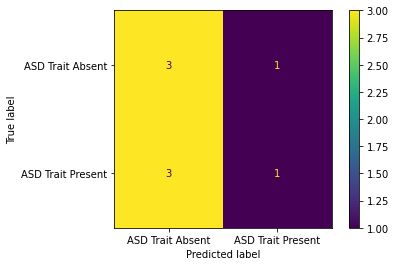

In [22]:
# Implement the random undersampler
df_ru_sampled_model = model_syn_training_data(model, RandomUnderSampler(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_ru_sampled_model, X_test, y_test, model_results, data_desc="Random Undersampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_ru_sampled_model, X_test, y_test)

Not different from the performance of the randomly oversampled training data.

### Implementing and Evaluating Nearmiss Undersampling Technique on Training Data

METRICS
F1 score: 0.57
ROC-AUC: 0.62
Accuracy: 0.62
Precision: 0.67
Recall: 0.50


              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.67      0.50      0.57         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8





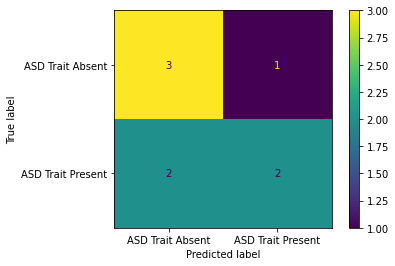

In [23]:
# Implement the random undersampler
df_nm_sampled_model = model_syn_training_data(model, NearMiss(n_neighbors=3), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_nm_sampled_model, X_test, y_test, model_results, data_desc="NearMiss Undersampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_nm_sampled_model, X_test, y_test)

Our trained Nearmiss Undersampled training data model performed better than the baseline model, randomly oversampled and randomly undersampled synthetic training data, evaluated on the baseline test data.

### Implementing and Evaluating SMOTE (Synthetic Minority Over-sampling Technique) on Training Data

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





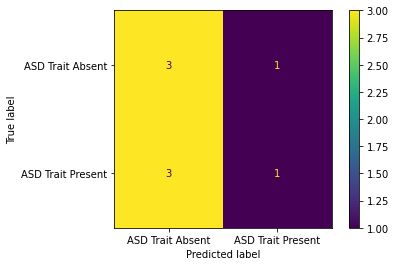

In [24]:
# Implement the random undersampler
df_smote_sampled_model = model_syn_training_data(model, SMOTE(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_smote_sampled_model, X_test, y_test, model_results, data_desc="SMOTE Oversampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_smote_sampled_model, X_test, y_test)

SMOTE performed similarly to the baseline data.

### Implementing and Evaluating ADASYN on Training Data

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





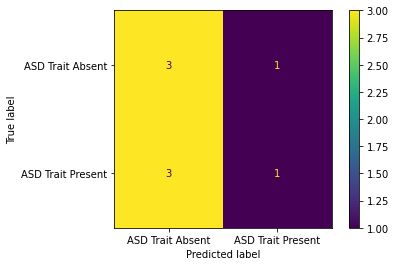

In [25]:
# Implement the random undersampler
df_asn_sampled_model = model_syn_training_data(model, ADASYN(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_asn_sampled_model, X_test, y_test, model_results, data_desc="ADASYN on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_asn_sampled_model, X_test, y_test)

ADASYN on training data when evaluated on the baseline test data, Performed similarly to the baseline model.

### Implementing and Evaluating Tomek Links on Training Data


METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





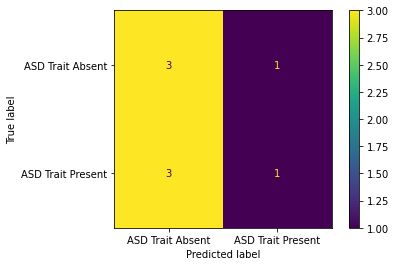

In [26]:
# Implement the random undersampler
df_tlink_sampled_model = model_syn_training_data(model, TomekLinks(sampling_strategy='auto'), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_tlink_sampled_model, X_test, y_test, model_results, data_desc="Tomek Links on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_tlink_sampled_model, X_test, y_test)

Tomek on training data when evaluated on the baseline test data, Performed similarly to the baseline model.

## Generating Synthetic data on the Baseline Dataset Using the Basic Techniques
Here, we will use the overall baseline data to synthesize our data and generate a new dataset, and then use our initial split function to split into training and test, followed with the evaluation of the split data on the newly synthesized data using RF classifier.

Firstly, we will generate another function to generate a new synthetic data based on selected technique on the overall data. (Note that the difference between this compared to the first one on the training set, is that training object is added to the function.

In [27]:
# define function to synthesize baseline data
def syn_baseline_data(df, target, technique):
  # Separate the target variable from the data
  X = df.drop(target, axis=1)
  y = df[target]

  # Perform resampling
  X_resampled, y_resampled = technique.fit_resample(X, y)

  # Combine the oversampled data
  df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
  df_resampled.columns = X.columns.tolist() + [target]
  return df_resampled

### Implementing and Evaluating Random Oversampling Technique on the baseline data

METRICS
F1 score: 0.92
ROC-AUC: 0.93
Accuracy: 0.90
Precision: 1.00
Recall: 0.86


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.86      0.92         7

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10





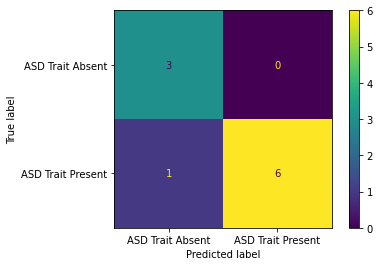

In [29]:
# Implement Random Oversampling on the baseline data
df_baseline_ros = syn_baseline_data(df_baseline, 'ASD', RandomOverSampler(random_state=42))

# Export to csv
df_baseline_ros.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_baseline-ros_11022023.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_ros, 'ASD')

# Fit the model to the training data
df_baseline_ros_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_ros_model, X_test, y_test, model_results, data_desc="Random Oversampling on Baseline Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_baseline_ros_model, X_test, y_test)

Randomly oversampled synthetic data generated on the baseline data before splitting, performed alot better with an F1-score of 0.92 and ROC-AUC of 0.93.

### Implementing and Evaluating Random Undersampling Technique on the baseline data

METRICS
F1 score: 0.67
ROC-AUC: 0.75
Accuracy: 0.83
Precision: 1.00
Recall: 0.50


              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6





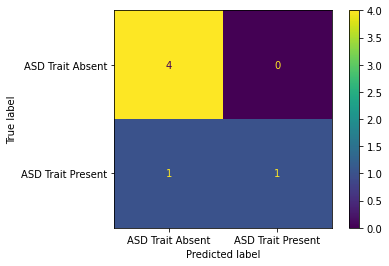

In [30]:
# Implement Random Undersampling on the baseline data
df_baseline_rus = syn_baseline_data(df_baseline, 'ASD', RandomUnderSampler(random_state=42))

# Export to csv
df_baseline_rus.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_baseline-rus_11022023.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_rus, 'ASD')

# Fit the model to the training data
df_baseline_rus_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_rus_model, X_test, y_test, model_results, data_desc="Random Undersampling on Baseline Data")

# Evaluate our df_baseline_rus_model on the test set
evaluate_model(df_baseline_rus_model, X_test, y_test)

Randomly undersampled synthetic data generated using the baseline data performed poorer than the randomly oversampled synthetic data. However, it still did better than the baseline model performance.

### Implementing and Evaluating Near Miss Technique on the baseline data

METRICS
F1 score: 0.50
ROC-AUC: 0.62
Accuracy: 0.67
Precision: 0.50
Recall: 0.50


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6





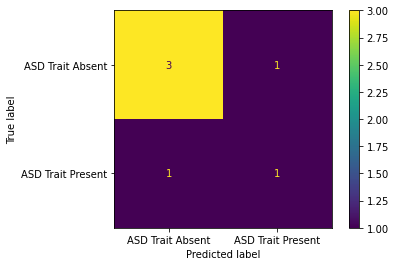

In [31]:
# Nearmiss gives a categorical error, hence the use of the encoded data
# Implement nearmiss on the baseline data
df_baseline_nearmiss = syn_baseline_data(df_baseline, 'ASD', NearMiss(n_neighbors=3))

# Export to csv
df_baseline_nearmiss.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_baseline-nearmiss_11022023.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_nearmiss, 'ASD')

# Fit the model to the training data
df_baseline_nearmiss_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_nearmiss_model, X_test, y_test, model_results, data_desc="NearMiss Undersampling on Baseline Data")

# Evaluate our df_baseline_nearmiss_model on the test set
evaluate_model(df_baseline_nearmiss_model, X_test, y_test)

Compared to the RUS and ROS synthetic data generated on the baseline data, Nearmiss performed lesser.

### Implementing and Evaluating SMOTE Technique on the baseline data

METRICS
F1 score: 0.83
ROC-AUC: 0.86
Accuracy: 0.80
Precision: 1.00
Recall: 0.71


              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.71      0.83         7

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10





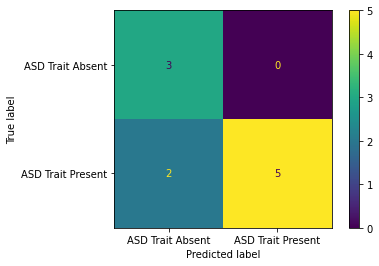

In [32]:
# SMOTE gives a categorical label error, hence the use of the encoded data
# Implement SMOTE on the baseline data
df_baseline_smote = syn_baseline_data(df_baseline, 'ASD', SMOTE(random_state=42))

# Export to csv
df_baseline_smote.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_baseline-smote_11022023.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_smote, 'ASD')

# Fit the model to the training data
df_baseline_smote_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_smote_model, X_test, y_test, model_results, data_desc="SMOTE Oversampling on Baseline Data")

# Evaluate our df_baseline_smote_model on the test set
evaluate_model(df_baseline_smote_model, X_test, y_test)

SMOTE also did better in performance when generated on the baseline data before splitting than the other techniques above, except Random oversampled synthetic data generated on baseline data.

### Implementing and Evaluating ADASYN on baseline data

METRICS
F1 score: 0.67
ROC-AUC: 0.66
Accuracy: 0.64
Precision: 0.80
Recall: 0.57


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.80      0.57      0.67         7

    accuracy                           0.64        11
   macro avg       0.65      0.66      0.63        11
weighted avg       0.69      0.64      0.64        11





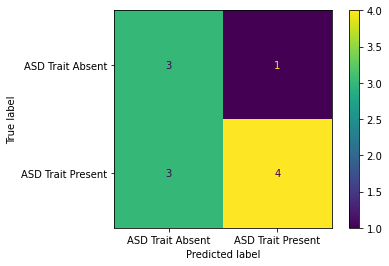

In [33]:
# ADASYN gives a categorical label error, hence the use of the encoded data
# Implement ADASYN on the baseline data
df_baseline_ADASYN = syn_baseline_data(df_baseline, 'ASD', ADASYN(random_state=42))

# Export to csv
df_baseline_ADASYN.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_baseline-ADASYN_11022023.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_ADASYN, 'ASD')

# Fit the model to the training data
df_baseline_ADASYN_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_ADASYN_model, X_test, y_test, model_results, data_desc="ADASYN on Baseline Data")

# Evaluate our df_baseline_ADASYN_model on the test set
evaluate_model(df_baseline_ADASYN_model, X_test, y_test)

### Implementing and Evaluating Tomeklink on baseline data

METRICS
F1 score: 0.75
ROC-AUC: 0.71
Accuracy: 0.71
Precision: 0.75
Recall: 0.75


              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.75      0.75      0.75         4

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7





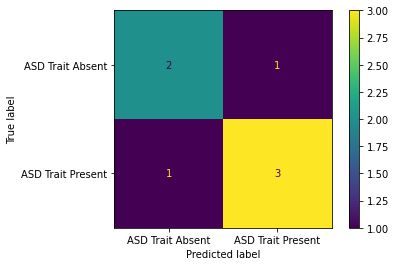

In [34]:
# Implement TomekLinks on the baseline data
df_baseline_TomekLinks = syn_baseline_data(df_baseline, 'ASD', TomekLinks(sampling_strategy='auto'))

# Export to csv
df_baseline_TomekLinks.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_baseline-TomekLinks_11022023.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_TomekLinks, 'ASD')

# Fit the model to the training data
df_baseline_TomekLinks_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_TomekLinks_model, X_test, y_test, model_results, data_desc="TOMEK Link on Baseline Data")

# Evaluate our df_baseline_TomekLinks_model on the test set
evaluate_model(df_baseline_TomekLinks_model, X_test, y_test)

Overall, using the baseline data to generate our synthetic data before splitting, did a great job when compared to the baseline model, and most especially the synthetic data generated with the Random Oversampled technique.

## Generating Synthetic data Using Synthetic Data Vault Package (SDV)
Synthetic data vault is an ecosystem of libraries, and we will use each of the library to generate synthetic data. Synthetic data can then be used to supplement, augment and in some cases replace real data when training Machine Learning models. Underneath the hood it uses several probabilistic graphical modeling and deep learning based techniques. For our single tabular data, we will use the following:
- GaussianCopula Model (based on copula funtions) https://sdv.dev/SDV/user_guides/single_table/gaussian_copula.html
- CTGAN Model (based on the GAN-based Deep Learning data synthesizer) https://sdv.dev/SDV/user_guides/single_table/ctgan.html
- CopulaGAN Model (is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.) https://sdv.dev/SDV/user_guides/single_table/copulagan.html
- TVAE Model (based on the VAE-based Deep Learning data synthesizer by the paper titled Modeling Tabular data using Conditional GAN) https://sdv.dev/SDV/user_guides/single_table/tvae.html

We will implement these techniques on the training data as well as on the overall data.

In [35]:
!pip install -q sdv;

### Implementing SDV on the Training Data
Similarly, we will divide our dataset into training and testing autism data firstly on the baseline data, without separating the target. We will then use the training dataset to synthesize the data, using each of the SDV library above. Afterwards, we will run thesame preprocessing step as we did earlier on each data, and train each with our randomforestclassifier model. Overall, we will be exposing our model to thesame condition, except this time, more training data using the SDV library. In most cases, this process is always good when trying out deep learning approach to training data, but let's see how this improve our classical model as well.

Note: We will be generating train and test data with the target combined at first, using thesame parameters as before. After we have synthesized the training data, we will split for modelling.

In [36]:
# Split the baseline data into train and test sets
df_baseline_train, df_baseline_test = train_test_split(df_baseline, test_size=0.2, random_state=42)

For the synthesis, we will use our `df_baseline_train`. We will run all the synthesis model at thesame time, and save each data. We will also need to install the sdv package.

In [37]:
len(df_baseline_train)

30

Now that we have the SDV package installed, let's try to synthesize our training data. Since we have 30 rows of data, let's go ahead to increase this to 5000 rows of training data, and see how that works on the test set we did not include in the synthetic data, which depicts more of real life data. This will help us assume if our model when trained on these quantity of data can actually generalize well on data it has not seen before.

In [38]:
# import all 4 sdv models under the single table scenario
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN
from sdv.tabular import TVAE

# load the models 
model_Gaussian = GaussianCopula()
model_CTGAN = CTGAN()
model_CopulaGAN = CopulaGAN()
model_TVAE = TVAE()

# fit the models on our training data
model_Gaussian.fit(df_baseline_train)
model_CTGAN.fit(df_baseline_train)
model_CopulaGAN.fit(df_baseline_train)
model_TVAE.fit(df_baseline_train)

# create synthetic data with each fitted model
new_data_model_Gaussian = model_Gaussian.sample(5000)
new_data_model_CTGAN = model_CTGAN.sample(5000)
new_data_model_CopulaGAN = model_CopulaGAN.sample(5000)
new_data_model_TVAE = model_TVAE.sample(5000)

# Export the new training set to csv as a checkpoint
new_data_model_Gaussian.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_training_syndata_sdv-guassian_11022023.csv', index=False)
new_data_model_CTGAN.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_training_syndata_sdv-ctgan_11022023.csv', index=False)
new_data_model_CopulaGAN.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_training_syndata_sdv-copgan_11022023.csv', index=False)
new_data_model_TVAE.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_training_syndata_sdv-tvae_11022023.csv', index=False)

We will now define a function to split our training and test set, and run thesame preprocessing and evaluation on each of the SDV model. `df_baseline_test` has been defined earlier when we split our data into training and test.

In [39]:
def split_SDV_training_data(new_data, target, df_baseline_test):
  # Split the data into train and test sets
  SDV_X_train = new_data.drop(target, axis=1)
  SDV_y_train = new_data[target]
  baseline_X_test = df_baseline_test.drop(target, axis=1)
  baseline_y_test = df_baseline_test[target]

  # Identify categorical columns
  cat_cols = [col for col in SDV_X_train.columns if SDV_X_train[col].dtype=='object']

  # Preprocess the categorical data
  enc = OneHotEncoder(handle_unknown='ignore')
  SDV_X_train_cat = enc.fit_transform(SDV_X_train[cat_cols])
  baseline_X_test_cat = enc.transform(baseline_X_test[cat_cols])

  # Preprocess the numerical data
  scaler = StandardScaler()
  SDV_X_train_num = scaler.fit_transform(SDV_X_train.drop(cat_cols, axis=1))
  baseline_X_test_num = scaler.transform(baseline_X_test.drop(cat_cols, axis=1))

  # Combine the preprocessed data
  SDV_X_train = np.hstack((SDV_X_train_cat.toarray(), SDV_X_train_num))
  baseline_X_test = np.hstack((baseline_X_test_cat.toarray(), baseline_X_test_num))

  return SDV_X_train, SDV_y_train, baseline_X_test, baseline_y_test

#### Evaluate Guassian SDV



In [40]:
# Implement training on the guassian data
Guassian_X_train, Guassian_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_Gaussian,
                                                                                               'ASD',
                                                                                               df_baseline_test)

# Fit the model to the training data
Guassian_data_model = model.fit(Guassian_X_train, Guassian_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(Guassian_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV Guassian on Training Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2886
           1       1.00      1.00      1.00      2114

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000





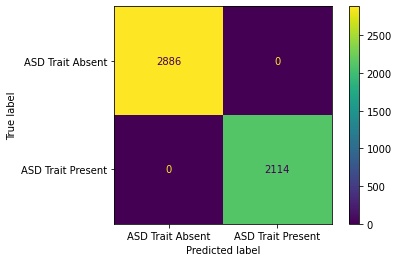

In [41]:
# Evaluate our Guassian_data_model on the train set
evaluate_model(Guassian_data_model, Guassian_X_train, Guassian_y_train)

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





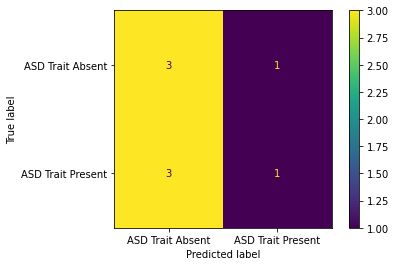

In [42]:
# Evaluate our Guassian_data_model on the test set
evaluate_model(Guassian_data_model, baseline_X_test, baseline_y_test)

Similar to all the synthetic data we have generated using the training data and tested on the test data it has not seen before.

#### Evaluating CTGAN SDV

In [43]:
# Implement training on the CTGAN data
CTGAN_X_train, CTGAN_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_CTGAN,
                                                                                         'ASD',
                                                                                         df_baseline_test)

# Fit the model to the training data
CTGAN_data_model = model.fit(CTGAN_X_train, CTGAN_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(CTGAN_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV CTGAN on Training Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4409
           1       1.00      1.00      1.00       591

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000





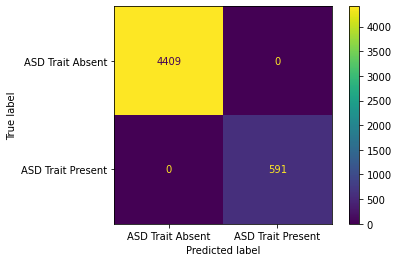

In [44]:
# Evaluate our CTGAN_data_model on the test set
evaluate_model(CTGAN_data_model, CTGAN_X_train, CTGAN_y_train)

METRICS
F1 score: 0.00
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.00
Recall: 0.00


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.00      0.00      0.00         4

    accuracy                           0.50         8
   macro avg       0.25      0.50      0.33         8
weighted avg       0.25      0.50      0.33         8





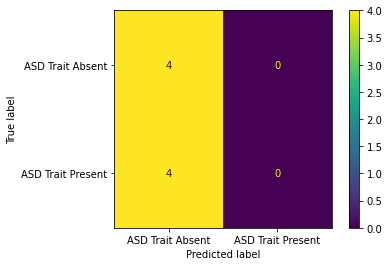

In [45]:
# Evaluate our CTGAN_data_model on the test set
evaluate_model(CTGAN_data_model, baseline_X_test, baseline_y_test)

CTGAN SDV synthetic data generated on the training data performed worse than the other synthetic data and baseline model we have built so far with an F1 score of 0.

#### Evaluating CopulaGAN SDV

In [46]:
# Implement training on the CopulaGAN data
CopulaGAN_X_train, CopulaGAN_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_CopulaGAN,
                                                                                                 'ASD',
                                                                                                 df_baseline_test)

# Fit the model to the training data
CopulaGAN_data_model = model.fit(CopulaGAN_X_train, CopulaGAN_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(CopulaGAN_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV CopulaGAN on Training Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4418
           1       1.00      1.00      1.00       582

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000





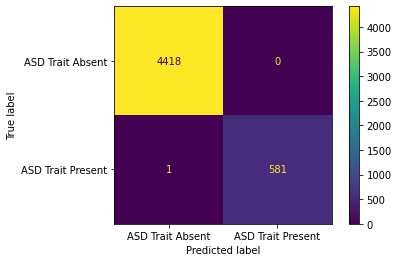

In [47]:
# Evaluate our CopulaGAN_data_model on the training set
evaluate_model(CopulaGAN_data_model, CopulaGAN_X_train, CopulaGAN_y_train)

METRICS
F1 score: 0.57
ROC-AUC: 0.62
Accuracy: 0.62
Precision: 0.67
Recall: 0.50


              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.67      0.50      0.57         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8





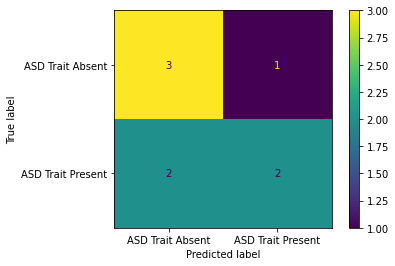

In [48]:
# Evaluate our CopulaGAN_data_model on the test set
evaluate_model(CopulaGAN_data_model, baseline_X_test, baseline_y_test)

Our copulaGAN data on training got a little bit of an improved score on the training data. Let's go on with the rest SDV techniques.

#### Evaluating TVAE SDV

In [49]:
# Implement training on the TVAE data
TVAE_X_train, TVAE_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_TVAE,
                                                                                       'ASD',
                                                                                       df_baseline_test)

# Fit the model to the training data
TVAE_data_model = model.fit(TVAE_X_train, TVAE_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(TVAE_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV TVAE on Training Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4465
           1       1.00      1.00      1.00       535

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000





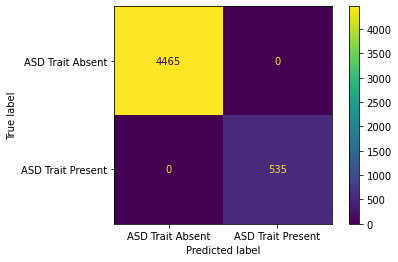

In [50]:
# Evaluate our TVAE_data_model on the training set
evaluate_model(TVAE_data_model, TVAE_X_train, TVAE_y_train)

METRICS
F1 score: 0.33
ROC-AUC: 0.50
Accuracy: 0.50
Precision: 0.50
Recall: 0.25


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8





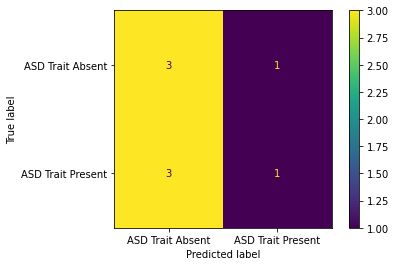

In [51]:
# Evaluate our TVAE_data_model on the test set
evaluate_model(TVAE_data_model, baseline_X_test, baseline_y_test)

As it is, our synthetic training data did not really perform very well on the baseline test data, while the only one that showed a little bit of promise was the SDV-CopulaGAN technique but just fair.

An assumption would be that since these models are not performing well on the training data across board, when evaluated with the baseline data it has not seen before generating the synthetic data, it shows it is overfitting. This could be because we modelled them on the training data only. As a result of this, we will go ahead to implement these models to generate the SDV synthetic data based on the whole data, and split afterwards to see how they perform.

We will utilize the initial df_baseline data

### Implementing SDV on the Overall Baseline Data
Here, we will use the baseline dataset to synthesize the data, using each of the SDV library . Afterwards, we will run thesame preprocessing step as we did earlier on each data, and train each with our randomforestclassifier model. Overall, we will be exposing our model to thesame condition, except this time, synthetic data is generated from the baseline data instead of the training data.

In [52]:
df_baseline.head()

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,...,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,0,2.641,0.398,2.604,0.472,0.558,2.215,61,0.701,212,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,1.105,0.218,1.000,0.265,0.500,2.556,2,0.026,21,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,3.158,0.449,2.719,0.501,0.394,1.218,57,0.606,233,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,2.394,0.462,1.979,0.488,0.527,1.905,40,0.519,165,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1,5.213,0.841,4.023,0.832,0.421,0.972,81,0.931,462,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [53]:
len(df_baseline)

38

Since we have 38 records in the baseline data, let's see how generating more records upto same 3000 we used for the training data would help our modelling. As mentioned earlier, SDV uses the deep learning technique to basically learn from the data and synthesize.

In [54]:
# import all 4 sdv models under the single table scenario
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN
from sdv.tabular import TVAE

# load the models 
model_Gaussian = GaussianCopula()
model_CTGAN = CTGAN()
model_CopulaGAN = CopulaGAN()
model_TVAE = TVAE()

# fit the models on our training data
model_Gaussian.fit(df_baseline)
model_CTGAN.fit(df_baseline)
model_CopulaGAN.fit(df_baseline)
model_TVAE.fit(df_baseline)

# create synthetic data with each fitted model
overall_data_model_Gaussian = model_Gaussian.sample(5000)
overall_data_model_CTGAN = model_CTGAN.sample(5000)
overall_data_model_CopulaGAN = model_CopulaGAN.sample(5000)
overall_data_model_TVAE = model_TVAE.sample(5000)

# Export the overall training set to csv as a checkpoint
overall_data_model_Gaussian.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_baseline-sdv-guassian_28012023_tosinharold.csv', index=False)
overall_data_model_CTGAN.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_baseline-sdv-ctgan_28012023_tosinharold.csv', index=False)
overall_data_model_CopulaGAN.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_baseline-sdv-copgan_28012023_tosinharold.csv', index=False)
overall_data_model_TVAE.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_baseline-sdv-tvae_28012023_tosinharold.csv', index=False)

Great! Now, we model and evaluate each data separately, using Random Forest Classifier, similar preprocessing method as we have used before and see where that leads us. We will use our initial `train_test_split` function to preprocess and split our data.

### Using the SDV Gaussian Synthetic Data Generated with the Baseline Data

In [55]:
# Preprocess and split overall Gaussian baseline data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_Gaussian, 'ASD')

# Fit the model to the training data
df_baseline_guassian_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_guassian_model, X_test, y_test, model_results, data_desc="SDV GUassian on Baseline Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2207
           1       1.00      1.00      1.00      1793

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000





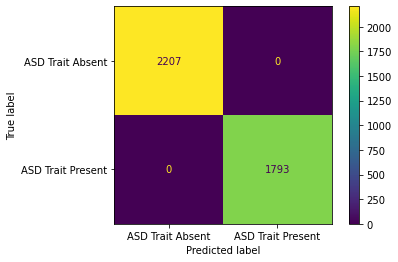

In [56]:
# Evaluate our df_baseline_guassian_model on the training set
evaluate_model(df_baseline_guassian_model, X_train, y_train)

METRICS
F1 score: 0.77
ROC-AUC: 0.80
Accuracy: 0.80
Precision: 0.83
Recall: 0.72


              precision    recall  f1-score   support

           0       0.77      0.87      0.82       525
           1       0.83      0.72      0.77       475

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000





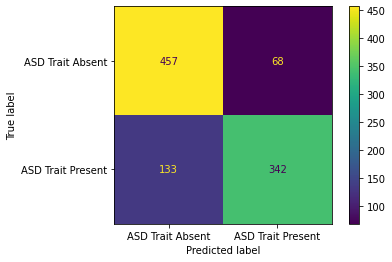

In [57]:
# Evaluate our df_baseline_guassian_model on the testing set
evaluate_model(df_baseline_guassian_model, X_test, y_test)

So, it seems we are getting a better model performance with synthetic data generated on the overall baseline data. Let's see the perfomance of the other SDV technique.

### Using the SDV CTGAN Synthetic Data Generated with the Baseline Data

In [58]:
# Preprocess and split overall CTGAN data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_CTGAN, 'ASD')

# Fit the model to the training data
df_baseline_CTGAN_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_CTGAN_model, X_test, y_test, model_results, data_desc="SDV CTGAN on Baseline Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3052
           1       1.00      1.00      1.00       948

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000





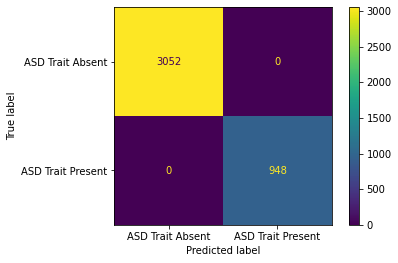

In [59]:
# Evaluate our df_baseline_CTGAN_model on the training set
evaluate_model(df_baseline_CTGAN_model, X_train, y_train)

METRICS
F1 score: 0.00
ROC-AUC: 0.50
Accuracy: 0.77
Precision: 0.00
Recall: 0.00


              precision    recall  f1-score   support

           0       0.77      1.00      0.87       768
           1       0.00      0.00      0.00       232

    accuracy                           0.77      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.59      0.77      0.67      1000





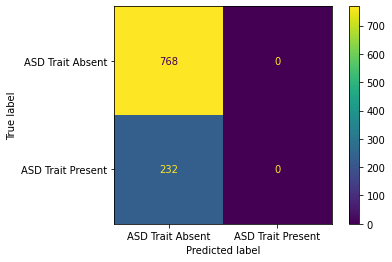

In [60]:
# Evaluate our df_baseline_CTGAN_model on the testing set
evaluate_model(df_baseline_CTGAN_model, X_test, y_test)

Just as the previous CTGAN synthesis on the training data, this equally performed poorly on the data synthesized using the baseline data. Shows serious overfitting. It seems SDV CTGAN technique is a no show.

### Using the SDV CopulaGAN Synthetic Data Generated with the Baseline Data

In [61]:
# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_CopulaGAN, 'ASD')

# Fit the model to the training data
df_baseline_copulaGAN_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_copulaGAN_model, X_test, y_test, model_results, data_desc="SDV CopulaGAN on Baseline Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      1548

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000





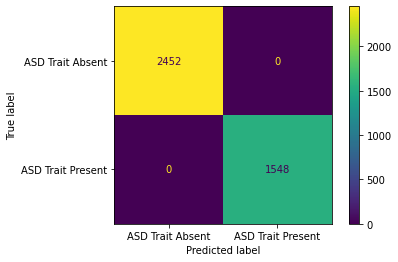

In [62]:
# Evaluate our df_baseline_CopulaGAN_model on the training set
evaluate_model(df_baseline_copulaGAN_model, X_train, y_train)

METRICS
F1 score: 0.10
ROC-AUC: 0.51
Accuracy: 0.61
Precision: 0.50
Recall: 0.05


              precision    recall  f1-score   support

           0       0.62      0.97      0.75       612
           1       0.50      0.05      0.10       388

    accuracy                           0.61      1000
   macro avg       0.56      0.51      0.43      1000
weighted avg       0.57      0.61      0.50      1000





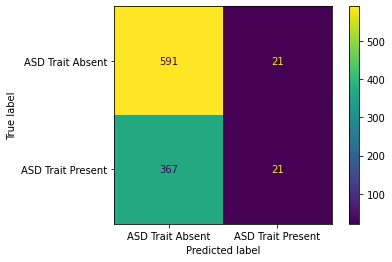

In [63]:
# Evaluate our df_baseline_CopulaGAN_model on the testing set
evaluate_model(df_baseline_copulaGAN_model, X_test, y_test)

Just as the CTGAN, CopulaGAN performed also poorly.

### Using the SDV TVAE Synthetic Data Generated with the Baseline Data

In [64]:
# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_TVAE, 'ASD')

# Fit the model to the training data
df_baseline_TVAE_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_TVAE_model, X_test, y_test, model_results, data_desc="SDV TVAE on Baseline Data")

METRICS
F1 score: 1.00
ROC-AUC: 1.00
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3983
           1       1.00      1.00      1.00        17

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000





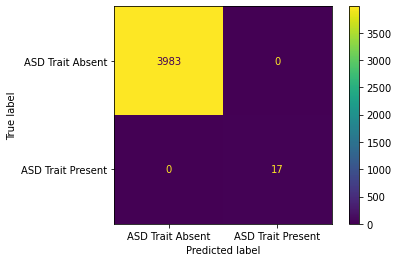

In [65]:
# Evaluate our df_baseline_TVAE_model on the training set
evaluate_model(df_baseline_TVAE_model, X_train, y_train)

METRICS
F1 score: 0.00
ROC-AUC: 0.50
Accuracy: 1.00
Precision: 0.00
Recall: 0.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       998
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       1.00      1.00      1.00      1000





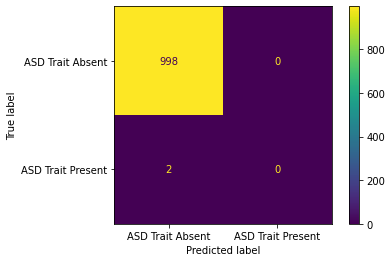

In [66]:
# Evaluate our df_baseline_TVAE_model on the testing set
evaluate_model(df_baseline_TVAE_model, X_test, y_test)

TVAE synthetic data generated from the overall data before splitting performed even worse. One thing we may also want to look at is the possibility of merging the best SDV technique to generate more data with the best technique for balanced class, to see how our model will perform on that data. However, based on all the above, let's bring it all together to see the synthetic data that performed better based on quantity and balanced classification.

## Bringing it all together

Now that we have all the techniques used in generating synthetic data at different level and evaluating using RF classifier, let's sort our `model_results` table to look at the performance from top to bottom for easy view.

In [67]:
# Generate the model_results table and sort from highest to smallest by F1 Score
model_results = model_results.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
model_results

,Data Description,F1 Score,ROC AUC,Accuracy,Precision,Recall
0,Random Oversampling on Baseline Data,0.923,0.929,0.900,1.000,0.857
1,SMOTE Oversampling on Baseline Data,0.833,0.857,0.800,1.000,0.714
2,SDV GUassian on Baseline Data,0.773,0.795,0.799,0.834,0.720
3,TOMEK Link on Baseline Data,0.750,0.708,0.714,0.750,0.750
4,ADASYN on Baseline Data,0.667,0.661,0.636,0.800,0.571
5,Random Undersampling on Baseline Data,0.667,0.750,0.833,1.000,0.500
6,NearMiss Undersampling on Training Data,0.571,0.625,0.625,0.667,0.500
7,SDV CopulaGAN on Training Data,0.571,0.625,0.625,0.667,0.500
8,NearMiss Undersampling on Baseline Data,0.500,0.625,0.667,0.500,0.500
9,SDV TVAE on Training Data,0.333,0.500,0.500,0.500,0.250


As shown in the table above, the best synthetic data generating technique for balanced class is Random Oversampling on Baseline data, while for quantity using SDV is SDV Guassian on baseline data. Now, let's use the randomly oversampled technique on the overall SDV guassian baseline data, and see how that synthetic data would perform.

## Merging Techniques: Implementing and Evaluating Randomly Oversampling Technique on the SDV Guassian Synthetic Data generated with the baseline data

METRICS
F1 score: 0.84
ROC-AUC: 0.85
Accuracy: 0.85
Precision: 0.86
Recall: 0.82


              precision    recall  f1-score   support

           0       0.83      0.87      0.85       559
           1       0.86      0.82      0.84       534

    accuracy                           0.85      1093
   macro avg       0.85      0.85      0.85      1093
weighted avg       0.85      0.85      0.85      1093





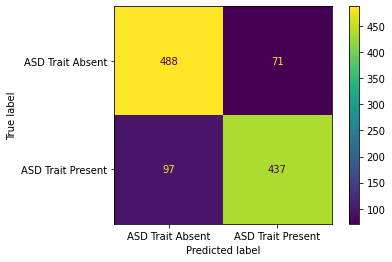

In [74]:
# Implement Random Oversampling on the overall sdv guassian data
df_overall_sdv_guassian_ros = syn_baseline_data(overall_data_model_Gaussian, 'ASD', RandomOverSampler(random_state=42))

# Export to csv
df_overall_sdv_guassian_ros.to_csv('/content/drive/MyDrive/DS-ML projects/ASD Prediction/data/nlp_syndata_overall_sdv_guassian_ros_11022023.csv', index=False)

# Preprocess and split the data
X_train, X_test, y_train, y_test = split_preprocessor(df_overall_sdv_guassian_ros, 'ASD')

# Fit the model to the training data
df_overall_sdv_guassian_ros_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_overall_sdv_guassian_ros_model, X_test, y_test, model_results, data_desc="Random Oversampling on Overall SDV Guassian Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_overall_sdv_guassian_ros_model, X_test, y_test)

In [76]:
# Generate the model_results table and sort from highest to smallest by F1 Score for thr top 5
model_results = model_results.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
model_results[:5]

,Data Description,F1 Score,ROC AUC,Accuracy,Precision,Recall
0,Random Oversampling on Baseline Data,0.923,0.929,0.900,1.000,0.857
1,Random Oversampling on Overall SDV Guassian Data,0.839,0.846,0.846,0.860,0.818
2,SMOTE Oversampling on Baseline Data,0.833,0.857,0.800,1.000,0.714
3,SDV GUassian on Baseline Data,0.773,0.795,0.799,0.834,0.720
4,TOMEK Link on Baseline Data,0.750,0.708,0.714,0.750,0.750


## Summary on Synthetic Data Generation

Having looked at different techniques to generate synthetic data and have been able to establish the performance of the baseline data and each synthetic data generated with the training data and the baseline data using Random Classifier model, here are few things to take note:

- Random Oversampling on Baseline data still had the highest F1 score of 0.923 and ROC AUC score of 0.929.
- Using our randomly oversampled technique to generate new synthetic data on the synthetic data generated using SDV Guassian technique on the baseline data, performed as second best. The introduction of the random oversampling technique on the SDV Guassian data, improved the performance of the model from 4th to 2nd.

Overall, the introduction of random oversamping (ROS) technique on our NLP extracted baseline data still remains the highest performing, and the introduction of the technique to the SDV Guassian synthetic generated data also improved its performance, making the ROS technique useful in our scenario.

**Nonetheless, it is worth paying attention to the following**: Since generating synthetic data on the training set to evaluate on the baseline test data it has never seen before gave a poor performance, it would be good to monitor how the final model would still perform in real life situation. However, with more data, using the ROS technique has a good potential to getting a better model, with a balanced class.

### Next Steps:
- Use the ROS generated data to test other classical, ensemble and bagging models to see how the performance would fair, compared to the random forest classifier.
- Tune the hyperparameters of the model for better performance
- Check for feature importance
- Perform error analysis using 
  - cross validation 
  - Check for bias on model prediction
  - Check for uncertainty on model prediction
  - Inspect SHAP values for model prediction
